# Visualizing MSI Images with Parametric UMAP.

Binning with m/z from 900 is used to create the segmentation.
Then we train parametric umap using only the non noise bins, with 1 output.

In [ ]:
import numpy as np
import joblib
from sklearn.decomposition import non_negative_factorization
from sklearn.metrics.pairwise import cosine_similarity
from visualizations import get_colors, show_factorization_on_image, visualizations_from_explanations
from matplotlib import pyplot as plt
from PIL import Image


NUM_COMPONENTS = 5
_cmap = plt.cm.get_cmap('gist_rainbow')
colors_for_components = [
    np.array(
        _cmap(i)) for i in np.arange(
        0,
        1,
        1.0 /
        NUM_COMPONENTS)]

# Create the segmentation mask/
ion_image = np.load("D:\\maldi\\tol_01_binarysearch_1_bin\\0.npy")
ion_image = ion_image[:, :, 600 :]
H = np.load("h_cosegmentation.npy")
ion_image = ion_image / (1e-6 + np.median(ion_image, axis=-1)[:, :, None])
vector = ion_image.reshape((-1, ion_image.shape[-1]))
w_new, h_new, n_iter = non_negative_factorization(vector, H=H, W=None, n_components=NUM_COMPONENTS, update_H=False, random_state=0)
explanations = w_new.transpose().reshape(NUM_COMPONENTS, ion_image.shape[0], ion_image.shape[1])
explanations[4, :] = 0
spatial_sum_visualization, global_percentile_visualization, normalized_sum, normalized_percentile = visualizations_from_explanations(ion_image, explanations, colors_for_components)
segmentation_mask = normalized_sum.argmax(axis=0)
segmentation_mask[ion_image.max(axis=-1) == 0] = 0
display(Image.fromarray(spatial_sum_visualization))

# Create the training data from the first image.
ion_image = np.load("D:\\maldi\\tol_None_5_bins\\0.npy")
ion_image = ion_image / (1e-6 + np.sum(ion_image, axis=-1)[:, :, None])
ion_image = ion_image / (1e-6 + np.percentile(ion_image, 99, axis=(0, 1))[None, None, :])
ion_image[ion_image > 1] = 1
#ion_image = ion_image / (1e-6 + np.max(ion_image, axis=-1)[:, :, None])
ion_image[normalized_sum.argmax() == 3] = 0


ion_image[segmentation_mask == 0] = 0
training_data = ion_image[:, :, :].reshape(-1, ion_image.shape[-1])
training_data = training_data[training_data.max(axis=-1) > 0]
print(training_data.shape)

In [1]:
import glob
import numpy as np
import joblib
from sklearn.decomposition import non_negative_factorization
from sklearn.metrics.pairwise import cosine_similarity
from visualizations import get_colors, show_factorization_on_image, visualizations_from_explanations
from matplotlib import pyplot as plt
from PIL import Image
from segmentation import preprocess

training_data = []
paths = glob.glob("D:\maldi\slides\slide2_notol_5_bin\*.npy")
for path in paths:
    # Create the segmentation mask/
    ion_image = np.load(path)[::2, ::2, :]
    ion_image = preprocess(ion_image)
    data = ion_image[ion_image.max(axis=-1) > 0]
    data = data.reshape(-1, ion_image.shape[-1])
    training_data.append(data)
    del ion_image
    
training_data = np.concatenate(training_data, axis=0)
print(training_data.shape)

(64827, 5005)


# Define the parametric UMAP deep neural network.
5005 outputs since we use the full range.

In [2]:
from umap.parametric_umap import ParametricUMAP
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(5005,)),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1)
])

umap_model = ParametricUMAP(encoder=encoder, n_components=1, n_neighbors=50, n_training_epochs=1, dims=(5005,), run_eagerly=True).fit(training_data)

umap_model.encoder.save("D:\\maldi\\parametric_umap_tol_None_5_bins_slide_2.keras")

d:\miniconda3\envs\dl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\miniconda3\envs\dl\Lib\site-packages\umap\parametric_umap.py:148: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  warn(


[[0.52693959 0.         1.         ... 0.         0.         0.98875807]
 [0.70793691 0.         0.         ... 0.         0.92026385 0.89745137]
 [0.37411405 0.         0.         ... 0.2946489  0.2134998  0.46799581]
 ...
 [0.         0.35936109 0.99410703 ... 0.49276162 0.38190242 0.68849187]
 [0.7698407  0.         0.         ... 0.29970627 0.10246091 0.        ]
 [0.1922728  0.         0.         ... 0.19929429 0.         0.        ]] None
(64827, 5005)
self.dims (5005,)
Epoch 1/10
14316/14316 [==============================] - 3759s 263ms/step - loss: 0.3233
Epoch 2/10
14316/14316 [==============================] - 2704s 189ms/step - loss: 0.3213
Epoch 3/10
14316/14316 [==============================] - 2577s 180ms/step - loss: 0.3209
Epoch 4/10
14316/14316 [==============================] - 2599s 182ms/step - loss: 0.3206
Epoch 5/10
14316/14316 [==============================] - 2627s 183ms/step - loss: 0.3205
Epoch 6/10
14316/14316 [==============================] - 2673s 187ms

: 

d:\miniconda3\envs\dl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


75/75 [==============================] - 1s 12ms/step
Colored image without region specific normalization


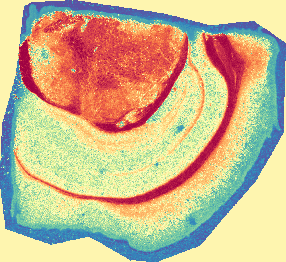

1D UMAP with per region color mapping


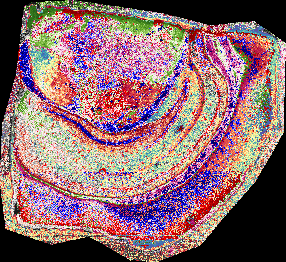

KeyboardInterrupt: 

In [1]:
from PIL import Image
import cv2
import joblib
import numpy as np
from umap.parametric_umap import load_ParametricUMAP
import glob
from parametric_umap import normalize_image_grayscale, image_histogram_equalization
import importlib
import utils
importlib.reload(utils)
from utils import brain_nmf_semantic_segmentation, brain_nmf_semantic_segmentation_highres
import tensorflow as tf
from sklearn.decomposition import non_negative_factorization
from visualizations import get_colors, get_qr_images, analyze_region_differences, get_difference_summary_table
from matplotlib import pyplot as plt
from collections import defaultdict
import tqdm
import cmapy

#encoder = tf.keras.models.load_model("D:\\maldi\\parametric_umap_tol_None_5_bins.keras")
encoder = tf.keras.models.load_model("D:\\maldi\\parametric_umap_tol_None_5_bins_normalized_sum_max.keras")

lowres_paths = glob.glob("D:\maldi\slides\slide2_notol_5_bin\\*.npy")
highres_paths = glob.glob("D:\maldi\slides\slide2_notol_5_bin\\*.npy")
#colors_maps=["Spectral", "PiYG", "RdGy", "seismic"]
#colors_maps = ["gist_rainbow", "hsv", "seismic", "cividis"]
#colors_maps = ["hsv", "twilight", "twilight_shifted", "seismic"]


#colors_maps = ["cividis", "magma", "viridis", "inferno", "plasma"]
#colors_maps=["Spectral", "PiYG", "RdGy", "seismic"]
colors_maps = ["hsv", "twilight", "twilight_shifted", "seismic"]
colors_maps = colors_maps * 10

# colors_maps =["Spectral", "PiYG", "RdGy", "seismic"]
# colors_maps += ["gist_rainbow", "hsv", "seismic", "cividis"]
# colors_maps += ["hsv", "twilight", "twilight_shifted", "seismic"]
# colors_maps = colors_maps * 4


for image_index, (path_for_segmentation, path_for_umap) in enumerate(zip(lowres_paths, highres_paths)):
    semantic_segmentation_labels = brain_nmf_semantic_segmentation_highres(path_for_segmentation)

    ion_image = np.load(path_for_umap)[:, :, :5005]

    ion_image = ion_image / (1e-6 + np.sum(ion_image, axis=-1)[:, :, None])
    ion_image = ion_image / (1e-6 + np.percentile(ion_image, 99, axis=(0, 1))[None, None, :])



    transformed = encoder.predict(ion_image.reshape(-1, ion_image.shape[-1]), batch_size=1000)
    transformed = transformed.reshape((ion_image.shape[0], ion_image.shape[1]))
    result = []
    print('Colored image without region specific normalization')
    num_bins = 2048
    normalized_transformed = normalize_image_grayscale(transformed)
    normalized_transformed = image_histogram_equalization(normalized_transformed, ion_image.max(axis=-1) > 0, num_bins) / (num_bins - 1)
    colored_image = np.uint8(normalized_transformed*255)
    colored_image = cv2.applyColorMap(colored_image, cmapy.cmap(colors_maps[0]))[:, :, ::-1]
    display(Image.fromarray(colored_image))
    print('1D UMAP with per region color mapping')

    for index, value in enumerate(np.unique(semantic_segmentation_labels)):
        mask = np.uint8(semantic_segmentation_labels == value) * 255
        #mask[ion_image.max(axis=-1) == 0] = 0
        #mask = cv2.medianBlur(mask, 3)
        mask[ion_image.max(axis=-1) == 0] = 0
        #display(Image.fromarray(mask))
        region_umap_representation = transformed.copy()
        region_umap_representation[mask == 0] = 0

        num_bins = 2048
        region_umap_representation = normalize_image_grayscale(region_umap_representation)
        region_umap_representation = image_histogram_equalization(region_umap_representation, mask, num_bins) / (num_bins - 1)
        region_gray_image = np.uint8(region_umap_representation * 255)
        region_color_image = cv2.applyColorMap(region_gray_image, cmapy.cmap(colors_maps[value]))
        region_color_image = region_color_image[:, :, ::-1]
        region_color_image[mask == 0] = 0
        result.append(region_color_image)
        
    #     mzs_per_bin = 1
    #     bins, digitized, region_pair_aucs = analyze_region_differences(ion_image, region_gray_image, mzs_per_bin, number_of_bins=3)
    #     qr_images = get_qr_images(region_gray_image, bins, digitized, region_pair_aucs, mzs_per_bin, color_scheme=colors_maps[value])
    #     display(Image.fromarray(np.hstack(qr_images)))
        
    #     top_mzs = {}
    #     for (i, j) in region_pair_aucs:
    #         _, full_range_aucs = region_pair_aucs[(i, j)]
    #         top_mzs[(i, j)] = {k: v for k, v in sorted(full_range_aucs.items(),
    #                                             key=lambda item: abs(item[1]))[::-1][:2000]}

    
    # table = get_difference_summary_table(region_gray_image, digitized, bins, top_mzs, colors_maps[value])
    # display(Image.fromarray(table))
    
    result = np.array(result)
    result = result.sum(axis=0)    
    result[np.array(ion_image.max(axis=-1) == 0)] = 0
    display(Image.fromarray(np.uint8(result)))

# Now the same with deep learning segmentation on slide 2

In [ ]:
import cv2
import torch
from PIL import Image
import cv2
import joblib
import numpy as np
from umap.parametric_umap import load_ParametricUMAP
import glob
from parametric_umap import normalize_image_grayscale, image_histogram_equalization
from utils import brain_nmf_semantic_segmentation
import tensorflow as tf
from sklearn.decomposition import non_negative_factorization
from visualizations import get_colors, get_qr_images, analyze_region_differences, get_difference_summary_table
from matplotlib import pyplot as plt
from collections import defaultdict
import tqdm
import cmapy
import segmentation
import importlib
importlib.reload(segmentation)
import segmentation
from segmentation import get_visualization, DeepLearningSegmentation

seg = DeepLearningSegmentation()

#encoder = tf.keras.models.load_model("D:\\maldi\\parametric_umap_tol_None_5_bins_normalized_sum_max.keras")
encoder = tf.keras.models.load_model("D:\\maldi\\parametric_umap_tol_None_5_bins_500neighbours.keras")
paths = glob.glob("D:\maldi\slides\slide5\slide5_timsoff_5_bins_notol_roi4\\*.npy")
#paths = glob.glob("D:\\maldi\\tol_None_5_bins\\*.npy")
colors_maps=["Spectral", "PiYG", "RdGy", "seismic"]
#colors_maps = ["gist_rainbow", "hsv", "seismic", "cividis"]
#colors_maps = ["hsv", "twilight", "twilight_shifted", "seismic"]
for image_index, path in enumerate(paths):

    img = np.load(path)[:, :, :5005]
    output = seg(img)
    output = torch.nn.Softmax(dim=0)(torch.from_numpy(output)).numpy()
    
    # output[1, :, :] -= 0.4
    # output[2, :, :] += 0.2

    semantic_segmentation_labels = output.argmax(axis=0)


    image_for_umap = np.load(path)[:, :, :5005]
    
    #image_for_umap = image_for_umap / (1e-6 + np.sum(image_for_umap, axis=-1)[:, :, None])
    #image_for_umap = image_for_umap / (1e-6 + np.percentile(image_for_umap, 99, axis=(0, 1))[None, None, :])


    transformed = encoder.predict(image_for_umap.reshape(-1, image_for_umap.shape[-1]), batch_size=1000)
    transformed = transformed.reshape((image_for_umap.shape[0], image_for_umap.shape[1]))
    result = []
    print('Colored image without region specific normalization')
    num_bins = 2048
    print(np.min(transformed), np.max(transformed), np.median(transformed))


    normalized_transformed = normalize_image_grayscale(transformed)
    normalized_transformed = image_histogram_equalization(normalized_transformed, image_for_umap.max(axis=-1) > 0, num_bins) / (num_bins - 1)
    colored_image = np.uint8(normalized_transformed*255)
    colored_image = cv2.applyColorMap(colored_image, cmapy.cmap(colors_maps[0]))[:, :, ::-1]
    display(Image.fromarray(colored_image))
    print('1D UMAP with per region color mapping')

    for index, value in enumerate(np.unique(semantic_segmentation_labels)):
        mask = np.uint8(semantic_segmentation_labels == value) * 255
        mask[image_for_umap.max(axis=-1) == 0] = 0
        mask = cv2.medianBlur(mask, 3)

        mask[image_for_umap.max(axis=-1) == 0] = 0
        display(Image.fromarray(mask))
        region_umap_representation = transformed.copy()
        region_umap_representation[mask == 0] = 0

        num_bins = 2048
        region_umap_representation = normalize_image_grayscale(region_umap_representation)
        region_umap_representation = image_histogram_equalization(region_umap_representation, mask, num_bins) / (num_bins - 1)
        region_gray_image = np.uint8(region_umap_representation * 255)
        region_color_image = cv2.applyColorMap(region_gray_image, cmapy.cmap(colors_maps[value]))
        region_color_image = region_color_image[:, :, ::-1]
        region_color_image[mask == 0] = 0
        result.append(region_color_image)
        
    #     mzs_per_bin = 1
    #     bins, digitized, region_pair_aucs = analyze_region_differences(image_for_umap, region_gray_image, mzs_per_bin, number_of_bins=3)
    #     qr_images = get_qr_images(region_gray_image, bins, digitized, region_pair_aucs, mzs_per_bin, color_scheme=colors_maps[value])
    #     display(Image.fromarray(np.hstack(qr_images)))
        
    #     top_mzs = {}
    #     for (i, j) in region_pair_aucs:
    #         _, full_range_aucs = region_pair_aucs[(i, j)]
    #         top_mzs[(i, j)] = {k: v for k, v in sorted(full_range_aucs.items(),
    #                                             key=lambda item: abs(item[1]))[::-1][:2000]}

    
    # table = get_difference_summary_table(region_gray_image, digitized, bins, top_mzs, colors_maps[value])
    # display(Image.fromarray(table))
    
    result = np.array(result)
    result = result.sum(axis=0)    
    result[np.array(image_for_umap.max(axis=-1) == 0)] = 0
    display(Image.fromarray(np.uint8(result)))